### Set up parallel computing

In [1]:
import ipyparallel
from ipyparallel import depend, require

# create client & view
rc = ipyparallel.Client()
dview = rc[:]
bview = rc.load_balanced_view() # you can set block=True to have this apply globally

# scatter 'id', so id=0,1,2 on engines 0,1,2
dview.scatter('node_id', rc.ids, flatten=True)
print("Engine IDs: ", dview['node_id'])
# create a Reference to `id`. This will be a different value on each engine
ref = ipyparallel.Reference('node_id')


Engine IDs:  [0, 1, 2]


### Parallel import of libraries

In [2]:
with dview.sync_imports(): # imports libs across dview
    import re, os, sys, pickle
    from pathlib import Path
    import numpy
    import pandas
    from pandas import DataFrame
    
dview.execute('numpy.random.seed(7)')

def scatter_func(f):
    dview.scatter(f.__name__, [f]*len(bview), flatten=True)    

importing re on engine(s)
importing os on engine(s)
importing sys on engine(s)
importing pickle on engine(s)
importing Path from pathlib on engine(s)
importing numpy on engine(s)
importing pandas on engine(s)
importing DataFrame from pandas on engine(s)


### Analysis dirs

In [3]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

### Local code in the scripts dir on the cluster

In [4]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

### Plotting setup

In [5]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

set1 = {'red': '#e41a1c', 'blue': '#377eb8', 'green': '#4daf4a',
        'purple': '#984ea3', 'orange': '#ff7f00', 
        'yellow': '#ffff33', 'brown': '#a65628'}

### Silence deprecation warnings (lots from seaborn)

In [6]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)

### Load meta data

In [7]:
# easy loading of meta data in a consistent manner across code
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())


## Compile data frame with ARGweaver TMRCA stats

In [8]:
from functools import wraps

def dfstore(groupby=[]):
    def decorator(func):
        @wraps(func)
        def func_wrapper(df):
            df = pandas.read_hdf(str(df))        
            if groupby:
                result_df = df.groupby(groupby).apply(func).reset_index(level=groupby)
#                result_df.index = result_df
            else:
                result_df = func(df)
            return result_df
        return func_wrapper
    return decorator

In [9]:
# DOES THIS MAKE SENSE IF THERE IS ONLY ONE ROW IN EACH GROUP.....


@dfstore(groupby=['MCMC_sample', 'chain'])
#@dfstore()
def tmrca_means(df):    
    return DataFrame({'start': [df.start.min()],
                      'end': [df.end.max()],
                      'tmrca_half': [df.tmrca_half.mean()], 
                      'rel_tmrca_half': [df.tmrca_half.mean() / df.tmrca.mean()], 
                      'tmrca': [df.tmrca.mean()] })

scatter_func(tmrca_means)

# dir with a hdf with tmrca stats for each window
df_list = list()
for reg in list(regions.keys())  + ['World']:
    tmrca_dir = steps_dir / 'argweaver/tmrca/{}'.format(reg)
    df = pandas.concat(dview.map(tmrca_means, sorted(tmrca_dir.iterdir())))
    df['region'] = reg
    df_list.append(df)
raw_stats = pandas.concat(df_list)
raw_stats.head()

,MCMC_sample,chain,end,rel_tmrca_half,start,tmrca,tmrca_half,region
0,0,1,100000,0.217147,0,37151.385384,8067.325587,WestEurasia
0,0,2,100000,0.152816,0,44548.546271,6807.723791,WestEurasia
0,10,1,100000,0.214021,0,36874.637772,7891.931018,WestEurasia
0,10,2,100000,0.171290,0,41477.573487,7104.693530,WestEurasia
0,20,1,100000,0.199866,0,42253.551011,8445.037677,WestEurasia


## Analyze convergence of mean statistics from samples in the two chains

Plot the tmrca and tmrca_half for each chain:

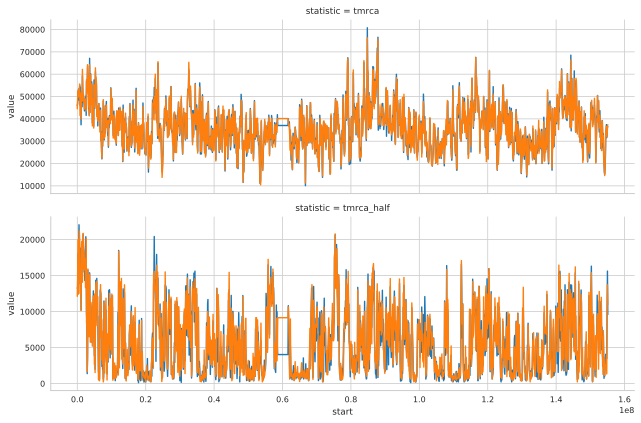

In [15]:
df = (raw_stats
      .loc[lambda df: df.region=='World']
      .groupby(['region', 'start', 'end', 'chain'])
      .mean()
      .reset_index()      
     )
plot_df = pandas.melt(df, 
                  id_vars=['start', 'chain'], 
                  value_vars=['tmrca', 'tmrca_half'], 
                  var_name='statistic', value_name='value')

g = sns.FacetGrid(plot_df, row='statistic', hue='chain', size=3, aspect=3, sharey=False)

fig = g.map(plt.plot, 'start', "value")

# fig = g.map(plt.plot, 'start', "value").fig
# mpld3.display(fig)

See if the correlation between arg stats in the two chains improve the longer they have run:

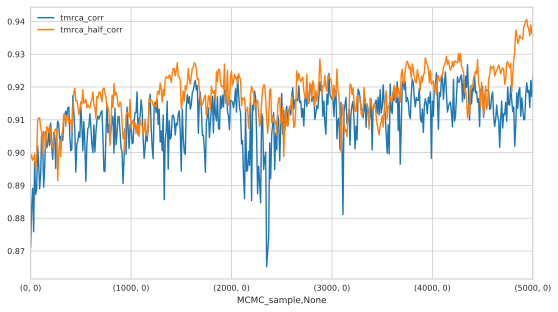

In [26]:
stats_list = ['tmrca', 'tmrca_half']

def cross_chain_corr(df):
    result_df = DataFrame()
    for stat in stats_list:
        chain0 = df.loc[df.chain == 1, ['start', stat]]
        chain1 = df.loc[df.chain == 2, ['start', stat]]
        both = pandas.merge(chain0, chain1, on='start', how='inner', 
                            suffixes=['_chain0', '_chain1'])
        result_df[stat + '_corr'] = [both[stat + '_chain0'].corr(both[stat + '_chain1'])]
    return result_df
        
g = (raw_stats#stats_by_sample_df
     .loc[lambda df: df.region=='World']
     .reset_index()
     .groupby('MCMC_sample')
     .apply(cross_chain_corr)
     .plot(figsize=(9, 5))
    )


## Write mean stats for merged chains to hdf

In [28]:
tmrca_stats = raw_stats.groupby(['region', 'start', 'end']).mean().reset_index()

# write to results
tmrca_stats.to_hdf(str(results_dir / 'tmrca_stats.hdf'), 'df', format='table', mode='w')    

## TMRCA and TMRCA_half across chrX

Plot the stats for both chains pooled:

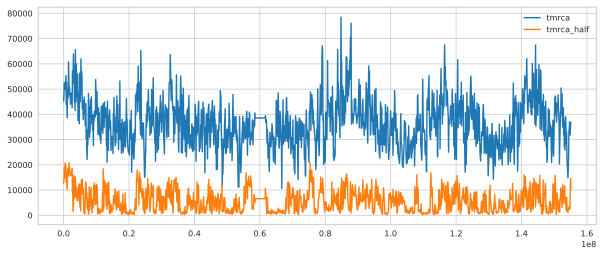

In [30]:
df = tmrca_stats.loc[tmrca_stats.region=='World']
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df.start, df.tmrca)
ax.plot(df.start, df.tmrca_half)
ax.legend(loc='upper right')
plt.show()

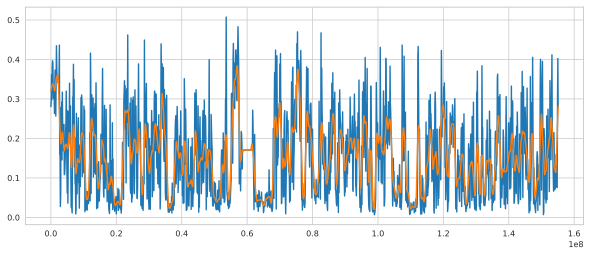

In [31]:
df = tmrca_stats.loc[tmrca_stats.region=='World']
fig, ax = plt.subplots(figsize=(10, 4))
ratio = df.tmrca_half/df.tmrca
ax.plot(df.start, ratio)

filtered = lowess(ratio, df.start, is_sorted=True, frac=0.01, it=0)
ax.plot(filtered[:,0], filtered[:,1])

plt.show()

Plot the $-\log\Big[\frac{TMRCA_{half}}{TMRCA}\Big]$

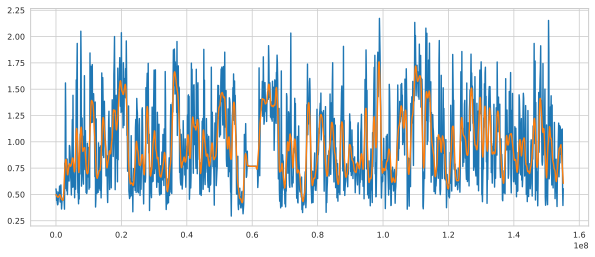

In [32]:
df = tmrca_stats.loc[tmrca_stats.region=='World']
fig, ax = plt.subplots(figsize=(10, 4))
log_ratio = -numpy.log10(df.tmrca_half/df.tmrca)
ax.plot(df.start, log_ratio)

filtered = lowess(log_ratio, df.start, is_sorted=True, frac=0.01, it=0)
ax.plot(filtered[:,0], filtered[:,1])

plt.show()

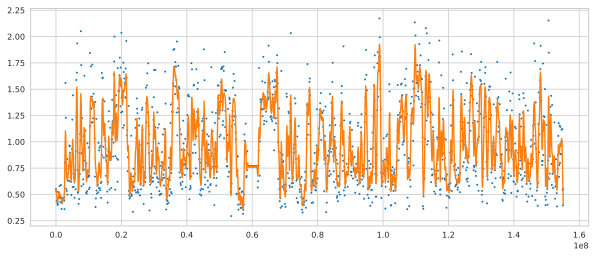

In [33]:
df = tmrca_stats.loc[tmrca_stats.region=='World']
fig, ax = plt.subplots(figsize=(10, 4))
log_ratio = -numpy.log10(df.tmrca_half/df.tmrca)
ax.plot(df.start, log_ratio, 'o', ms=2)

filtered = lowess(log_ratio, df.start, is_sorted=True, frac=0.005, it=0)
ax.plot(filtered[:,0], filtered[:,1])

plt.show()